In [1]:
import numpy as np
from scipy import signal
import json
from utilities import *
from utilitiesDL import *
from OFDMparam import *
from CFOcorr import *
from getModFeat import *
import random
import os
from glob import glob
from collections import defaultdict

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
pi = math.pi

In [2]:
imgSizePsk = 15
imgSizeQam = 100
datasetType = 'sim' # {sim, real}
dataType = 'seq' # {img, seq}
coord = 'sph'

SNRVec = np.arange(5, 51, 5, dtype=int)
trainMode = 'train' # {test, train}

inputSampRate = 20e6
longestPreambleLen = 0
dataSamplingRate = 30.72e6
inputNHalfSubfr = 6
nSymFeatNR = 14

lenHalfSubfr = int(0.5e-3 * dataSamplingRate)
removeNull = True
angleMod = False
testFlag = False

inputJson = './inputJson/testNR.json'
classJson = './inputJson/class/classes.json'

f = open(inputJson)
dataPath = json.load(f)['data_path']
print(dataPath)

fClass = open(classJson)
classJson = json.load(fClass)

protocolList = np.array(classJson['protocolList'])
CPOptList = np.array(classJson['CPOptList'], dtype=object)
CPLenList = np.array(classJson['CPLenList'], dtype=object)
modList = np.array(classJson['modList'], dtype=object)

/project/iarpa/byungjun/cyclo_modul_OFDM/simulation/train/NRDL/


In [3]:
dataDict = {file:[] for file in protocolList}
for i, protocol in enumerate(protocolList):
    dataDict[protocol] = {file:[] for file in CPOptList[i]}
    for CPOpt in CPOptList[i]:
        dataDict[protocol][CPOpt] = {file:[] for file in modList[i]}
        for mod in modList[i]:
            dataDict[protocol][CPOpt][mod] = {file:[] for file in SNRVec}
            for SNR in SNRVec:
                dataDict[protocol][CPOpt][mod][SNR] = defaultdict(list)

printCount = 0
for subFolder in os.walk(dataPath):
    if datasetType == 'sim':
        dirFilenameList = glob(subFolder[0] + '/*.32cf')
    elif datasetType == 'real':
        dirFilenameList = glob(subFolder[0] + '/*.iq')
    if len(dirFilenameList) != 0:
        print(subFolder[0].split("/")[-1], len(dirFilenameList), end=' ')
        printCount += 1
    if printCount == 5:
        print()
        printCount = 0

    for fileIndex, dirFileName in enumerate(dirFilenameList):
        # break
        if datasetType == 'sim':
            extLen = 5
        elif datasetType == 'real':
            extLen = 3
        fileName = dirFileName.split("/")[-1][:-extLen]
        # print(dirFileName[:-5])
        # print(fileName, end=' ')
        # fileProtocol = (dirFileName.split("/")[-1][:-5]).split("_")[0]
        # fileCPOpt = (dirFileName.split("/")[-1][:-5]).split("_")[1]
        # fileMod = int((dirFileName.split("/")[-1][:-5]).split("_")[2])
        # fileSNR = int((dirFileName.split("/")[-1][:-5]).split("_")[4])
        fileProtocol = fileName.split("_")[0]
        fileCPOpt = fileName.split("_")[1]
        fileMod = int(fileName.split("_")[2])
        fileSNR = int(fileName.split("_")[4])

        fileProtocolIndex = int(np.where(protocolList == fileProtocol)[0])
        if not fileMod in modList[fileProtocolIndex]:
            continue
        fileModIndex = int(np.where(np.array(modList[fileProtocolIndex]) == fileMod)[0])
        
        dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['label'].append(fileModIndex)
        if datasetType == 'sim':
            load_out = np.fromfile(dirFileName, dtype=np.float32)
            data = load_out[np.arange(0, load_out.shape[0], 2)] +\
                1j * load_out[np.arange(1, load_out.shape[0], 2)]
            loadMeta = json.load(open(dirFileName[:-5] + '.metadata'))
            indexNRDL = getindexNRDL(loadMeta, 1)

        elif datasetType == 'real':
            fileIndex = int(fileName.split("_")[7])
            # print(fileSNR, fileIndex)
            data = np.fromfile(dirFileName, dtype=np.complex64)
            if fileIndex < 10:
                metaFileName = dirFileName[:-4] + '1.metadata'
            else:
                metaFileName = dirFileName[:-5] + str(int(np.ceil(fileIndex/10))) + '.metadata'
            loadMeta = json.load(open(metaFileName))
            indexNRDL = getindexNRDL(loadMeta, np.mod(fileIndex, 10))

        dataRes = signal.resample_poly(data, dataSamplingRate, inputSampRate)
        if fileProtocol == 'NRDLa':
            nSubC = 512
            inputLenCFOEst = int(0.25e-3 * dataSamplingRate)
            if fileCPOpt == 'Normal':
                CPLen = 36
                addInputLen = 2208 + int((nSubC+CPLen)/2)
                nSymHalfSubfr = 28
            else:
                CPLen = 128
                addInputLen = 0
                nSymHalfSubfr = 24
        elif fileProtocol == 'NRDLb':
            nSubC = 1024
            CPLen = 72
            addInputLen = 4400 + int((nSubC+CPLen)/2)
            nSymHalfSubfr = 14
            inputLenCFOEst = int(0.5e-3 * dataSamplingRate)
        elif fileProtocol == 'NRDLc':
            nSubC = 2048
            CPLen = 144
            addInputLen = 8784 + int((nSubC+CPLen)/2)
            nSymHalfSubfr = 7
            inputLenCFOEst = int(1e-3 * dataSamplingRate)
        
        inputLen = inputNHalfSubfr * lenHalfSubfr + addInputLen
        preambleLen = 0
        longestPreambleLen = 0

        inputStartIndex = int(random.randint(1000, 10000))
        inputIQ = dataRes[inputStartIndex : inputStartIndex+inputLen]
        # print(fileSNR, fileIndex, inputIQ.shape[0], end=' ')
        [firstIndex, firstSymIndex] = findFirstIndexNR(inputIQ, nSubC, CPLen)
        if fileCPOpt == 'Extended':
            [firstIndexTruth, firstSymIndex] = findTrueFirstIndexNR(inputStartIndex, nSubC, CPLen)
        firstSymIndex = firstSymIndex + int(np.floor((inputStartIndex + firstIndex) / 15360) * nSymHalfSubfr)
        # print(dataRes.shape, inputLen, inputStartIndex, firstIndexTruth, firstSymIndexTruth)
        inputIQ_CFO = corrCFO(inputIQ, nSubC, CPLen, firstIndex, dataSamplingRate, 2)
        feat = getModFeatNR(inputIQ_CFO, indexNRDL, nSubC, CPLen, nSymFeatNR, angleMod, firstIndex, firstSymIndex)
        
        if dataType == 'img':
            dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['input'].append(imgData(feat, imgSizeQam, angleMod))
        elif dataType == 'seq':
            feat = feat[np.where(~np.isnan(feat))[0], np.where(~np.isnan(feat))[1]]
            if feat.shape[0] < 2240:
                feat = np.pad(feat, (0, 2240-feat.shape[0]), 'constant', constant_values=(0, 0))
            feat = feat[:2240].reshape(56, 40)
            # print(feat.shape)
            dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['input'].append(sphData(feat))
        
for i, protocol in enumerate(protocolList):
    for CPOpt in CPOptList[i]:
        for mod in modList[i]:
            numFile = 0
            for SNR in SNRVec:
                numFile += len(dataDict[protocol][CPOpt][mod][SNR]['label'])
            print(protocol, CPOpt, str(mod), numFile, end=' ')
    print(' ')

NRDLc_Normal_1024qam 800 NRDLc_Normal_64qam 800 NRDLc_Normal_16qam 800 NRDLc_Normal_qpsk 800 NRDLc_Normal_256qam 800 
NRDLa_Extended_qpsk 400 NRDLa_Extended_1024qam 400 NRDLa_Extended_16qam 400 NRDLa_Normal_256qam 400 

/home/byk004/23-cyclo_modul_OFDM/python/utilities.py:153: RuntimeWarning: invalid value encountered in remainder
  pkRem = np.mod(pkMat, nSubC+CPLen)


NRDLa_Normal_64qam 400 
NRDLa_Extended_64qam 400 NRDLa_Normal_16qam 400 NRDLa_Normal_qpsk 400 NRDLa_Normal_1024qam 400 NRDLa_Extended_256qam 400 
NRDLb_Normal_64qam 800 NRDLb_Normal_16qam 800 NRDLb_Normal_1024qam 800 NRDLb_Normal_qpsk 800 NRDLb_Normal_256qam 800 
wlanHT Extended 2 0 wlanHT Extended 4 0 wlanHT Extended 16 0 wlanHT Extended 64 0 wlanHT Normal 2 0 wlanHT Normal 4 0 wlanHT Normal 16 0 wlanHT Normal 64 0  
wlanHE Extended 2 0 wlanHE Extended 4 0 wlanHE Extended 16 0 wlanHE Extended 64 0 wlanHE Extended 256 0 wlanHE Extended 1024 0 wlanHE Medium 2 0 wlanHE Medium 4 0 wlanHE Medium 16 0 wlanHE Medium 64 0 wlanHE Medium 256 0 wlanHE Medium 1024 0 wlanHE Normal 2 0 wlanHE Normal 4 0 wlanHE Normal 16 0 wlanHE Normal 64 0 wlanHE Normal 256 0 wlanHE Normal 1024 0  
NRDLa Extended 4 400 NRDLa Extended 16 400 NRDLa Extended 64 400 NRDLa Extended 256 400 NRDLa Normal 4 400 NRDLa Normal 16 400 NRDLa Normal 64 400 NRDLa Normal 256 400  
NRDLb Normal 4 800 NRDLb Normal 16 800 NRDLb Norm

dataRes: (307200,)
97108 9335
9335 544 9 -15


IndexError: list index out of range

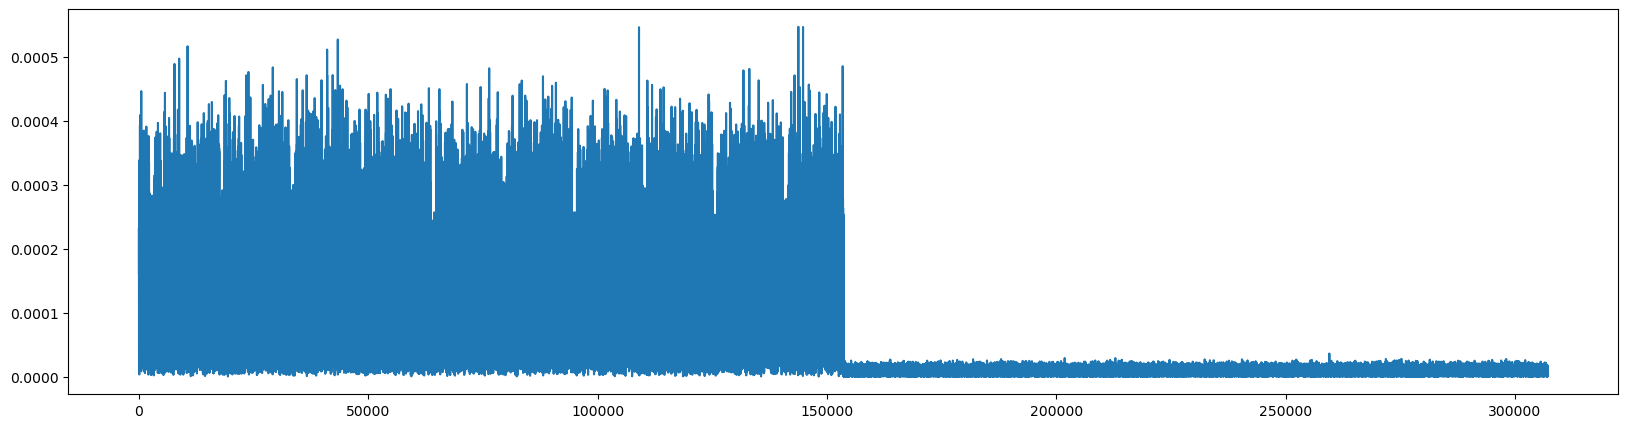

In [5]:
dirFileName = '/project/iarpa/byungjun/cyclo_modul_OFDM/walk_test/NRDLb_Normal_16_0_25_20_10_2.32cf'
dirMetadataFile = open('/project/iarpa/byungjun/cyclo_modul_OFDM/walk_test/NRDLb_Normal_16_0_25_20_10_2.metadata')
loadMetadata = json.load(dirMetadataFile)

data = np.fromfile(dirFileName, dtype=np.complex64)
dataRes = signal.resample_poly(data, dataSamplingRate, inputSampRate)
print('dataRes:', dataRes.shape)

preambleLen = 1200
nSubC = 1024
CPLen = 72
addInputLen = 4400 + int((nSubC+CPLen)/2) # 2208, 4400, 8784
inputNHalfSubfr = 6
inputLen = inputNHalfSubfr * lenHalfSubfr + addInputLen

# for _ in range(100):
inputStartIndex = int(random.randint(1000, 10000))
print(inputLen, inputStartIndex)
inputIQ = dataRes[inputStartIndex : inputStartIndex+inputLen]

plt.figure(figsize=(20,5))
plt.plot(np.abs(dataRes))

[firstIndexEst, firstSymIndexEst] = findFirstIndexNR(inputIQ, nSubC, CPLen)
if CPLen == 128:
    [firstIndexTruth, firstSymIndexEst] = findTrueFirstIndexNR(inputStartIndex, nSubC, CPLen)
# firstSymIndexEst = firstSymIndexEst + int(np.floor((inputStartIndex + firstIndexEst) / 15360) * 7)

print(inputStartIndex, firstIndexEst, firstSymIndexEst, (nSubC+CPLen)*firstSymIndexEst - (firstIndexEst+inputStartIndex))
indexNRDL = getindexNRDL(loadMetadata, 7)
inputIQ_CFO = corrCFO(inputIQ, nSubC, CPLen, firstIndexEst, dataSamplingRate, 2)

nSym = 7
angleMod = True
feat = getModFeatNR(inputIQ_CFO, indexNRDL, nSubC, CPLen,\
                    nSym, angleMod, firstIndexEst, firstSymIndexEst)
plt.figure(figsize=(4,4))
plt.scatter(np.real(feat), np.imag(feat))

CFOtruth = getCFOtruth(loadMetadata)
print(CFOtruth, estCFO(inputIQ, nSubC, CPLen, firstIndexEst, dataSamplingRate))

imgDataResult = np.squeeze(imgData(feat, imgSizeQam, True))
plt.figure(figsize=(4,4))
plt.imshow(imgDataResult)

dataRes: (307200,)
97108 2000
2000 208 2 -16
-406987.44718381925 12428.936118943484
<class 'numpy.ndarray'>


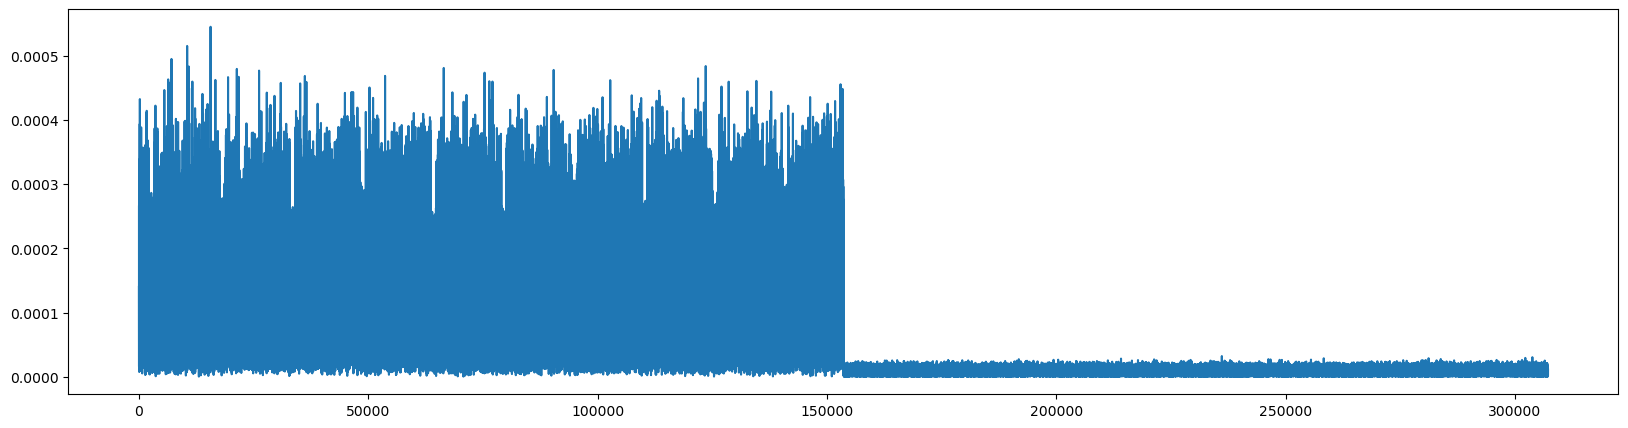

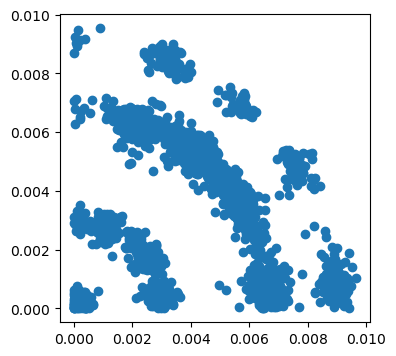

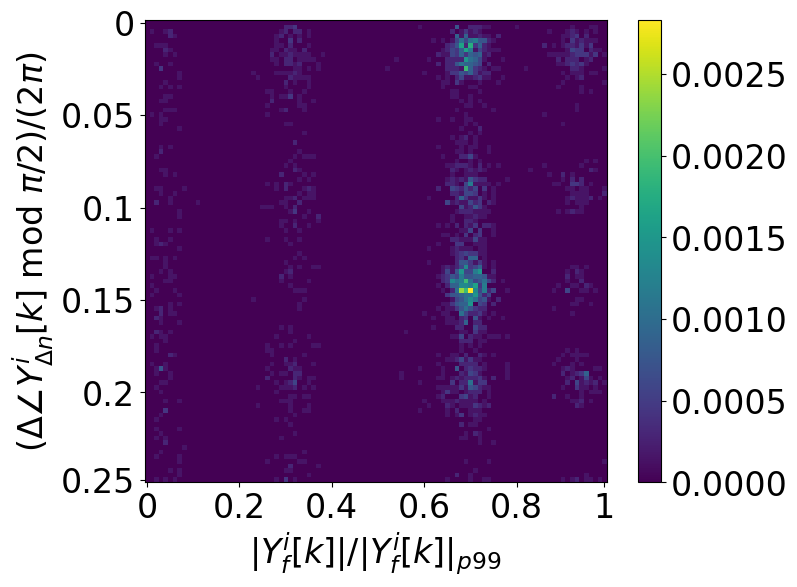

In [12]:
from matplotlib.font_manager import FontProperties
prop = FontProperties()

dirFileName = '/project/iarpa/byungjun/cyclo_modul_OFDM/walk_test/test_NRDL/NRDLb_Normal_16_0_25_20_10_2.32cf'
dirMetadataFile = open('/project/iarpa/byungjun/cyclo_modul_OFDM/walk_test/test_NRDL/NRDLb_Normal_16_0_25_20_10_2.metadata')
loadMetadata = json.load(dirMetadataFile)

data = np.fromfile(dirFileName, dtype=np.complex64)
dataRes = signal.resample_poly(data, dataSamplingRate, inputSampRate)
print('dataRes:', dataRes.shape)

preambleLen = 1200
nSubC = 1024
CPLen = 72
addInputLen = 4400 + int((nSubC+CPLen)/2) # 2208, 4400, 8784
inputNHalfSubfr = 6
inputLen = inputNHalfSubfr * lenHalfSubfr + addInputLen

# for _ in range(100):
inputStartIndex = int(2000)
print(inputLen, inputStartIndex)
inputIQ = dataRes[inputStartIndex : inputStartIndex+inputLen]

plt.figure(figsize=(20,5))
plt.plot(np.abs(dataRes))

[firstIndexEst, firstSymIndexEst] = findFirstIndexNR(inputIQ, nSubC, CPLen)
if CPLen == 128:
    [firstIndexTruth, firstSymIndexEst] = findTrueFirstIndexNR(inputStartIndex, nSubC, CPLen)
# firstSymIndexEst = firstSymIndexEst + int(np.floor((inputStartIndex + firstIndexEst) / 15360) * 7)

print(inputStartIndex, firstIndexEst, firstSymIndexEst, (nSubC+CPLen)*firstSymIndexEst - (firstIndexEst+inputStartIndex))
indexNRDL = getindexNRDL(loadMetadata, 1)
inputIQ_CFO = corrCFO(inputIQ, nSubC, CPLen, firstIndexEst, dataSamplingRate, 2)

nSym = 7
angleMod = True
feat = getModFeatNR(inputIQ_CFO, indexNRDL, nSubC, CPLen,\
                    nSym, angleMod, firstIndexEst, firstSymIndexEst)
plt.figure(figsize=(4,4))
plt.scatter(np.real(feat), np.imag(feat))

CFOtruth = getCFOtruth(loadMetadata)
print(CFOtruth, estCFO(inputIQ, nSubC, CPLen, firstIndexEst, dataSamplingRate))

imgDataResult = np.squeeze(imgData(feat, imgSizeQam, True))
print(type(imgDataResult))
# plt.figure(figsize=(4,4))
# pos = plt.imshow(imgDataResult/6717*4)
# imgDataResult = np.flip(imgDataResult, 0)

fig = plt.figure(figsize=(8,6))
pos = plt.imshow(imgDataResult/6717)
plt.xticks([0, 20, 40, 60, 80, 99], [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=24)
# plt.yticks([99, 80, 60, 40, 20, 0], [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=24)
plt.yticks([0, 20, 40, 60, 80, 99], [0, 0.05, 0.1, 0.15, 0.2, 0.25], fontsize=24)

plt.xlabel('$|Y_f^i[k]|/|Y_f^i[k]|_{\t{p}99}$', fontsize=24, fontproperties=prop)
# 𝑓 [𝑘]|/max(𝑖,𝑘 ) |𝑌𝑖 𝑓 [𝑘]|')
plt.ylabel(r'($\Delta \angle Y_{\Delta n}^i[k]$ mod $\pi/2$)/$(2\pi)$', fontsize=24)
# print('$Y_f^i[k]/2\pi$')
cb = plt.colorbar(pos)
for t in cb.ax.get_yticklabels():
     t.set_fontsize(24)


-55.208264808978555
(2, 56, 40)


TypeError: Invalid shape (2, 56, 40) for image data

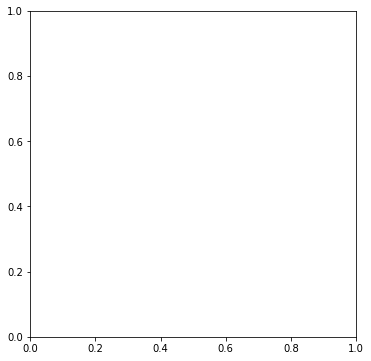

In [5]:
from matplotlib.font_manager import FontProperties
prop = FontProperties()
# prop.set_file('STIXGeneral.ttf')

print(sum(sum(sum(dataDict['NRDLb']['Normal'][16][30]['input'][2]))))
imgDataResult = np.squeeze(dataDict['NRDLb']['Normal'][16][30]['input'][2]/6717*4)
print(dataDict['NRDLb']['Normal'][16][30]['input'][2].shape)
fig = plt.figure(figsize=(8,6))
pos = plt.imshow(imgDataResult)
plt.xticks([0, 20, 40, 60, 80, 99], [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=16)
plt.yticks([0, 20, 40, 60, 80, 99], [0, 0.05, 0.1, 0.15, 0.2, 0.25], fontsize=16)
plt.xlabel('$|Y_f^i[k]|$/max$_{(i,k)}|Y_f^i[k]|$', fontsize=16, fontproperties=prop)
plt.ylabel(r'$\angle Y_f^i[k]/2\pi$', fontsize=16)
# print('$Y_f^i[k]/2\pi$')
plt.colorbar(pos)

In [4]:
trList = list()
valList = list()
cudaID = 3
batchSize = 32
# trainSNRVec = range(5, 41, 5)
# trainSNRVec = [0, 0, 15, 25, 30, 40]
# trainSNRVec = [0, 0, 0, 0, 0, 0]
SNRThres = 5
trainSNRVec = [SNRThres, SNRThres, SNRThres, SNRThres, SNRThres, SNRThres]

for i, protocol in enumerate(protocolList):
    for CPOpt in CPOptList[i]:
        for iMod, mod in enumerate(modList[i]):
            trDataCount = 0
            valDataCount = 0
            for SNR in SNRVec:
                # dataset = sphDataset(dataDict[protocol][CPOpt][mod][SNR],cuda_id=cudaID)
                dataset = imgDataset(dataDict[protocol][CPOpt][mod][SNR],testFlag,cuda_id=cudaID)

                if iMod >= 10:
                    numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][SNR]['label']) / 2))
                    numTotData = int(np.ceil(len(dataDict[protocol][CPOpt][mod][SNR]['label'] ) / 2))
                else:
                    numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][SNR]['label'])))
                    numTotData = len(dataDict[protocol][CPOpt][mod][SNR]['label'])

                if SNR >= trainSNRVec[iMod]:
                    # print(SNR, trainSNRVec[iMod])
                    trList.append(torch.utils.data.Subset(dataset,range(numTrData)))
                    valList.append(torch.utils.data.Subset(dataset,range(numTrData, numTotData)))
                # valDataCount += (numTotData - numTrData)

                if SNR < trainSNRVec[iMod]:
                    numTrData = 0
                    numTotData = 0
                # print(protocol, CPOpt, str(mod), numTrData, numTotData)
                trDataCount += numTrData
                valDataCount += (numTotData - numTrData)

            print(protocol, CPOpt, str(mod), trDataCount, valDataCount)

trDataset = torch.utils.data.ConcatDataset(trList) # concatenating dataset lists
valDataset = torch.utils.data.ConcatDataset(valList)

trLoader = DataLoader(trDataset,batch_size=batchSize,shuffle=True)
valLoader = DataLoader(valDataset,batch_size=batchSize,shuffle=True)

print('Training data size: '+str(len(trDataset))+' Test data size: '+str(len(valDataset)))

wlanHT Extended 2 0 0
wlanHT Extended 4 0 0
wlanHT Extended 16 0 0
wlanHT Extended 64 0 0
wlanHT Normal 2 0 0
wlanHT Normal 4 0 0
wlanHT Normal 16 0 0
wlanHT Normal 64 0 0
wlanHE Extended 2 0 0
wlanHE Extended 4 0 0
wlanHE Extended 16 0 0
wlanHE Extended 64 0 0
wlanHE Extended 256 0 0
wlanHE Extended 1024 0 0
wlanHE Medium 2 0 0
wlanHE Medium 4 0 0
wlanHE Medium 16 0 0
wlanHE Medium 64 0 0
wlanHE Medium 256 0 0
wlanHE Medium 1024 0 0
wlanHE Normal 2 0 0
wlanHE Normal 4 0 0
wlanHE Normal 16 0 0
wlanHE Normal 64 0 0
wlanHE Normal 256 0 0
wlanHE Normal 1024 0 0
NRDLa Extended 4 320 80
NRDLa Extended 16 320 80
NRDLa Extended 64 320 80
NRDLa Extended 256 320 80
NRDLa Normal 4 320 80
NRDLa Normal 16 320 80
NRDLa Normal 64 320 80
NRDLa Normal 256 320 80
NRDLb Normal 4 640 160
NRDLb Normal 16 640 160
NRDLb Normal 64 640 160
NRDLb Normal 256 640 160
NRDLc Normal 4 640 160
NRDLc Normal 16 640 160
NRDLc Normal 64 640 160
NRDLc Normal 256 640 160
Training data size: 7680 Test data size: 1920


In [5]:
# nClass = 6
inputSym = 40
LR = 5e-4
criterion = torch.nn.CrossEntropyLoss()

saveNRModelPath = './saveDLModel/selected/NRSeqSingle_C4.cpkt'
# saveQamModelPath = './saveDLModel/candidate/wifiHEImgQam10.cpkt'

if dataType == 'img':
    loadedNRNet = NRImgNet(4, removeNull)
elif dataType == 'seq':
    loadedNRNet = wifiSeqNet(4, removeNull)
loadedNRNet.apply(init_weights)

if cudaID is not None: loadedWifiNet = loadedNRNet.cuda(cudaID)

opt = torch.optim.Adam(loadedWifiNet.parameters(),lr=LR,weight_decay=0.01)
loadedWifiNet.train()   # setting training flag


wifiSeqNet(
  (conv1): Conv2d(2, 4, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=2464, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [9]:
accTrainList = []
accValidList = []
bestAcc = 0.0
patience = 0
fastConvergeFlag = True
nEpoch = 150

saveModelPath = saveNRModelPath
print('save model path:', saveModelPath)
torch.set_num_threads(1)
for epoch in range(nEpoch):
    runningLoss = 0.0
    for i, data in enumerate(trLoader):
        # print('train:', i)
        targets = data['target']
        opt.zero_grad()
        trInput = data['input']
        # print(data['input'].shape)

        outputs = loadedWifiNet(trInput)
        loss = criterion(outputs, targets)
        # print('backprop')
        loss.backward()
        opt.step()
        runningLoss += loss.item()

    avgLoss = runningLoss/len(trLoader)
    accTrain = getAcc(trLoader, loadedWifiNet)
    print('epoch: ', epoch, 'train loss: ', round(avgLoss, 4),\
        'accuracy: ', round(accTrain, 4))
    
    # getting valid error
    runningLoss = 0.0
    for i, data in enumerate(valLoader):
        # print('valid:', i)
        labels = data['target']
        validInput = data['input']

        outputs = loadedWifiNet(validInput)
        valLoss = criterion(outputs, labels)
        runningLoss += valLoss.item()

    avgValLoss = runningLoss/len(valLoader)
    accValid = getAcc(valLoader, loadedWifiNet)
    pred_l,target_l = getPreds(valLoader, loadedWifiNet)

    if bestAcc < accValid:
        bestAcc = accValid
        print('saving model')
        torch.save(loadedWifiNet.state_dict(), saveModelPath)  # saving model with best test accuracy
        patience = 0
        
    print('test loss: ', round(avgValLoss, 4), 'test accuracy:', round(accValid, 4))

    accTrainList.append(accTrain)
    accValidList.append(accValid)
    
    # early stopping if the model converges twice
    patience += 1
    if patience > 20:
        if fastConvergeFlag == True:
            LR = LR/10
            opt = torch.optim.Adam(loadedWifiNet.parameters(),lr=LR,weight_decay=0.01)
            fastConvergeFlag = False
            patience = 0
            print('Fast Converge finishes!')
        else:
            break

print('best test accuracy:', round(bestAcc, 4))

save model path: ./saveDLModel/selected/NRSeqSingle_C4.cpkt
epoch:  0 train loss:  1.0782 accuracy:  0.4677
saving model
test loss:  1.1642 test accuracy: 0.4333
epoch:  1 train loss:  1.0749 accuracy:  0.4719
test loss:  1.1735 test accuracy: 0.4208
epoch:  2 train loss:  1.0778 accuracy:  0.475
test loss:  1.1565 test accuracy: 0.4292
epoch:  3 train loss:  1.0764 accuracy:  0.4729
saving model
test loss:  1.177 test accuracy: 0.4375
epoch:  4 train loss:  1.0761 accuracy:  0.4667
test loss:  1.1789 test accuracy: 0.4333
epoch:  5 train loss:  1.0751 accuracy:  0.4708
test loss:  1.1405 test accuracy: 0.4333
epoch:  6 train loss:  1.0739 accuracy:  0.4656
test loss:  1.1632 test accuracy: 0.4333
epoch:  7 train loss:  1.0739 accuracy:  0.4771
saving model
test loss:  1.1798 test accuracy: 0.4417
epoch:  8 train loss:  1.0737 accuracy:  0.4698
test loss:  1.1719 test accuracy: 0.4375
epoch:  9 train loss:  1.0741 accuracy:  0.4708
test loss:  1.1708 test accuracy: 0.425
epoch:  10 tra

In [10]:
# print(nClass)
cudaID = 3
batchSize = 32
# loadedNRNet = NRImgNet(4, removeNull)
loadedNRNet = wifiSeqNet(4, removeNull)

if cudaID is not None: loadedNRNet = loadedNRNet.cuda(cudaID)

saveNRModelPath = './saveDLModel/selected/NRSeqSingle_C4.cpkt'

# path for saving model
testSNRVec = range(5, 41, 5)
loadedNRNet.load_state_dict(torch.load(saveNRModelPath))

trListCumul = list()
valListCumul = list()
for SNR in testSNRVec:
    trList = list()
    valList = list()

    for i, protocol in enumerate(protocolList):
        for CPOpt in CPOptList[i]:
            for mod in modList[i]:
                dataset = imgDataset(dataDict[protocol][CPOpt][mod][SNR],testFlag,cuda_id=cudaID)
                
                numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][SNR]['label'])))
                numTotData = len(dataDict[protocol][CPOpt][mod][SNR]['label'])

                # print(protocol, CPOpt, str(mod), numTrData, numTotData)                
                trList.append(torch.utils.data.Subset(dataset,range(numTrData)))
                valList.append(torch.utils.data.Subset(dataset,range(numTrData, numTotData)))

                trListCumul.append(torch.utils.data.Subset(dataset,range(numTrData)))
                valListCumul.append(torch.utils.data.Subset(dataset,range(numTrData, numTotData)))
                
    trDataset = torch.utils.data.ConcatDataset(trList) # concatenating dataset lists
    valDataset = torch.utils.data.ConcatDataset(valList)

    trDatasetCumul = torch.utils.data.ConcatDataset(trListCumul) # concatenating dataset lists
    valDatasetCumul = torch.utils.data.ConcatDataset(valListCumul)

    trLoader = DataLoader(trDataset,batch_size=batchSize,shuffle=True)
    valLoader = DataLoader(valDataset,batch_size=batchSize,shuffle=True)

    trLoaderCumul = DataLoader(trDatasetCumul,batch_size=batchSize,shuffle=True)
    valLoaderCumul = DataLoader(valDatasetCumul,batch_size=batchSize,shuffle=True)

    print(len(trDataset), len(valDataset))
    accTest = getAcc(valLoader, loadedNRNet)
    # accTest = getAccWifi(valLoader, loadedWifiPskNet, loadedWifiQamNet)

    print(SNR, accTest)

accTestCumul = getAcc(valLoaderCumul, loadedNRNet)
# accTestCumul = getAccWifi(valLoaderCumul, loadedWifiPskNet, loadedWifiQamNet)
print('cumul:', accTestCumul)

960 240
5 0.2708333333333333
960 240
10 0.3458333333333333
960 240
15 0.3875
960 240
20 0.4166666666666667
960 240
25 0.4166666666666667
960 240
30 0.4083333333333333
960 240
35 0.475
960 240
40 0.44166666666666665
cumul: 0.3953125


[Text(0, 0, 'QPSK'),
 Text(0, 1, '16QAM'),
 Text(0, 2, '64QAM'),
 Text(0, 3, '256QAM')]

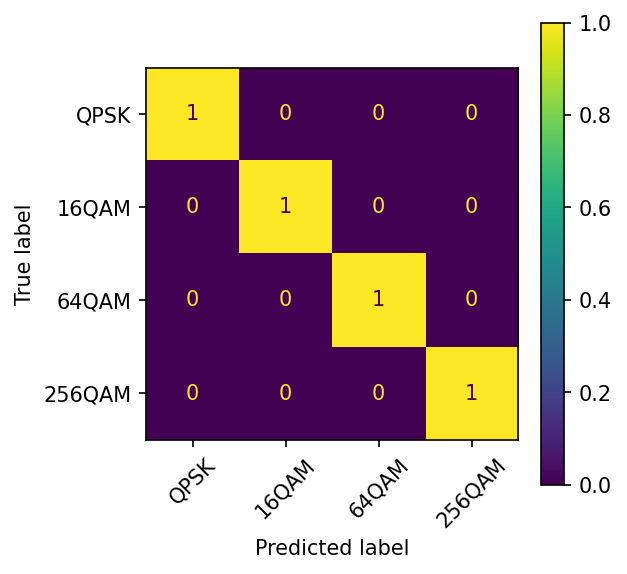

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

testSNR = 30
valList = list()
for i, protocol in enumerate(protocolList):
    for CPOpt in CPOptList[i]:
        for mod in modList[i]:
            dataset = imgDataset(dataDict[protocol][CPOpt][mod][testSNR],testFlag,cuda_id=cudaID)
            
            numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][testSNR]['label'])))
            numTotData = len(dataDict[protocol][CPOpt][mod][testSNR]['label'])

            # print(protocol, CPOpt, str(mod), numTrData, numTotData)                
            trList.append(torch.utils.data.Subset(dataset,range(numTrData)))
            valList.append(torch.utils.data.Subset(dataset,range(numTrData, numTotData)))
            
trDataset = torch.utils.data.ConcatDataset(trList) # concatenating dataset lists
valDataset = torch.utils.data.ConcatDataset(valList)

trLoader = DataLoader(trDataset,batch_size=batchSize,shuffle=True)
valLoader = DataLoader(valDataset,batch_size=batchSize,shuffle=True)

pred, target = getPreds(valLoader, loadedNRNet)

# font = {'size'   : 15}
# plt.rc('font', **font)

cm = confusion_matrix(target,pred,normalize ='true')
for i in range(2):
    for j in range(2):
        cm[i, j] = round(cm[i, j], 2)
# cm[2, 0] = round(cm[2, 0], 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4,4), dpi =150)
disp.plot(ax=ax)

modNameList = []
for mod in modList[1]:        
    if mod == 2:
        continue
        modul_name = 'BPSK'
    elif mod == 4:
        # continue
        modul_name = 'QPSK'
    elif mod == 16:
        # continue
        modul_name = '16QAM'
    elif mod == 64:
        # break
        # continue
        modul_name = '64QAM'
    elif mod == 256:
        # break
        modul_name = '256QAM'
    elif mod == 1024:
        break
        modul_name = '1024QAM'

    modNameList.append(modul_name)
plt_labels = modNameList
ax.set_xticklabels(plt_labels, rotation=45)
ax.set_yticklabels(plt_labels)

In [19]:
SNRVec = np.arange(40, 41, 2, dtype=int)
FFTsize = 4096
tauVec = np.array([64, 256, 512, 1024, 2048])
CPLenList = [[16, 8], [64, 32, 16], [128, 36], [72], [144]]
CPOptList = np.array([np.array(['Extended', 'Normal']   ),\
    np.array(['Extended', 'Medium', 'Normal']),\
    np.array(['Extended', 'Normal']),\
    np.array(['Normal']), np.array(['Normal'])], dtype=object)
protocolList = np.array(['wlanHT', 'wlanHE', 'NRDLa', 'NRDLb', 'NRDLc'])

In [20]:
load_out = np.fromfile('/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHT/wlanHT_Extended_16qam/wlanHT_Extended_16_0_30_20_0.4_2.32cf',\
    dtype=np.float32)
f = open('/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHT/wlanHT_Extended_16qam/wlanHT_Extended_16_0_30_20_0.4_2.metadata')
loadMetadata = json.load(f)

data = load_out[np.arange(0, load_out.shape[0], 2)] +\
                    1j * load_out[np.arange(1, load_out.shape[0], 2)]

FileNotFoundError: [Errno 2] No such file or directory: '/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHT/wlanHT_Extended_16qam/wlanHT_Extended_16_0_30_20_0.4_2.32cf'

In [9]:
from torchsummary import summary
summary(loadedWifiNet, input_size=(1, 50, 50))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.